# Loading
This notebook will show how to load the data from a real measurement to analyze it.

In the previous examples we have seen how to create our measurements via forward modeling (`1-forward modeling.ipynb`) and how to analyze them
(`2-analyzing.ipynb`), either via fitting or the Modified Beer-Lambert law. The last piece we are missing is how to load a real-world measurement
to be able to analyze it.

The `utils.data_loaders` module implements the tools needed for this task. It can handle two types of measurement: those taken with the
ALV7004/USB-FAST hardware correlator, and those taken with the Swabian TimeTagger20.

## Hardware correlator
Let's start easy, with the hardware correlator. The measurement gets saved as a series of `.asc` text files, with each file representing an
iteration. We can use the `utils.data_loaders.read_asc` function to read one such file:

In [1]:
from utils import data_loaders
import matplotlib.pyplot as plt
import numpy as np

file = "data/PRM_084_T0_Occ/PRM_084_Occm_0000.ASC"
data = data_loaders.read_asc(file)
data.keys()

dict_keys(['date', 'time', 'integration_time', 'countrate', 'tau', 'g2_norm'])

`read_asc` returns the data as a dictionary, with keys `date`, `time`, `integration_time`, `countrate`, `tau`, `g2_norm`.
From here we can easily plot the autocorrelation curves (one per channel):

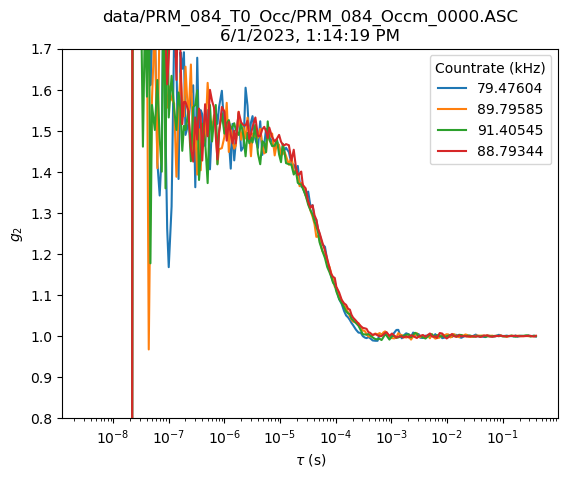

In [2]:
plt.semilogx(data["tau"], data["g2_norm"])
plt.legend(data["countrate"], title="Countrate (kHz)")
plt.xlabel(r"$\tau$ (s)")
plt.ylabel(r"$g_2$")
plt.ylim((0.8, 1.7))
plt.title(f"{file}\n{data["date"]}, {data["time"]}")
plt.show()

This is pretty straightforward, but we want to load the whole measurement at once to be able to process it using the utilities we have seen
in `2-analyzing.ipynb`. To this end, `data_loaders` implements the `DataLoaderALV` class, which does just that. To use it, first we
create an instance by passing the list of data files to the class constructor, and then we call the `load_data()` method on the instance.
Note that `load_data()` does not return anything, rather, it stores the info about the measurement in the class attributes:
* `countrate`: Array of shape `(n_iterations, len(channels))` containing the countrate for each channel in each
    iteration.
* `tau`: Array of shape `(n_bins,)` containing the time delays.
* `g2_norm`: Array of shape `(n_bins, n_iterations, len(channels))` containing the normalized g2 data.

In [3]:
import os

data_files = os.listdir("data/PRM_084_T0_Occ/")[:-1]   # We exclude the last file, since it's incomplete and can't be read properly
data_files = [os.path.join("data/PRM_084_T0_Occ/", file) for file in data_files]
loader = data_loaders.DataLoaderALV(data_files)
loader.load_data()
countrate, tau, g2_norm = loader.countrate, loader.tau, loader.g2_norm

Now that we have loaded the data, we can analyze it however we want. For example, we can plot the countrate during the measurement.

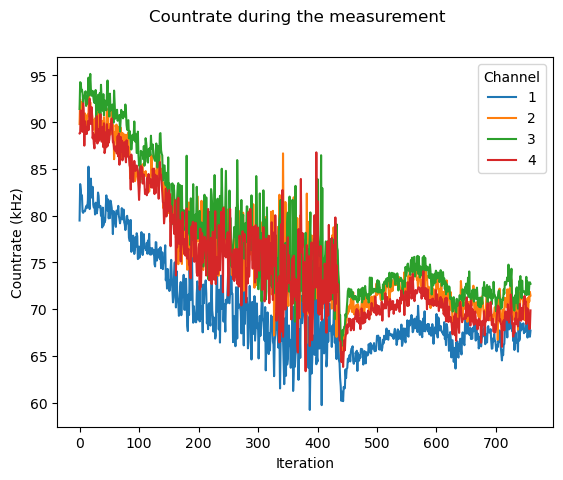

In [4]:
plt.plot(countrate)
plt.xlabel("Iteration")
plt.ylabel("Countrate (kHz)")
plt.legend(range(1, 5), title="Channel")
plt.suptitle("Countrate during the measurement")
plt.show()

To analyze `g2_norm`, we need to average it over the detection channels first. This can easily be done via `np.mean` with `axis=-1`, or,
alternatively, we can calculate a weighted average of the curves, using the countrates as weights. This latter approach is implemented in
`data_loaders.weigh_g2()`, as the following code shows:

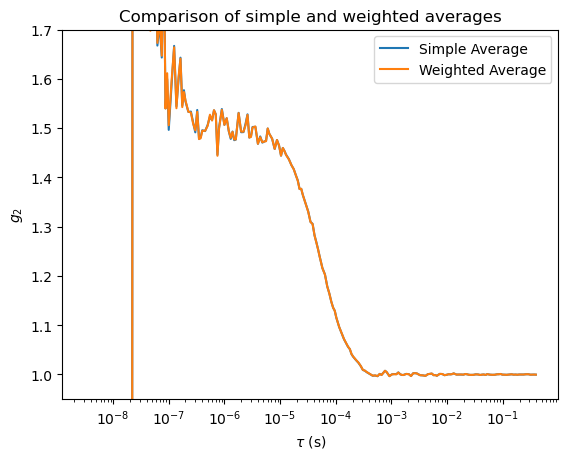

In [5]:
g2_norm_simple_avg = np.mean(g2_norm, axis=-1)
g2_norm_weighted_avg = data_loaders.weigh_g2(g2_norm, countrate)

plt.semilogx(tau, g2_norm_simple_avg[:, 0], label="Simple Average")
plt.semilogx(tau, g2_norm_weighted_avg[:, 0], label="Weighted Average")
plt.legend()
plt.xlabel(r"$\tau$ (s)")
plt.ylabel(r"$g_2$")
plt.ylim((0.95, 1.7))
plt.title("Comparison of simple and weighted averages")
plt.show()

In this case the countrate was similar across all channels, so the simple and weighted averages are basically the same. Nonetheless,
the weighted average can prove useful in case of non-uniform countrate, to avoid having to discard noisy channels altogether.

Now that we have the autocorrelation curves in a familiar format, we can analyze them using the methods we saw in `2-analyzing.ipynb`.
For example, we can fit with the homogeneous semi-infinite model:

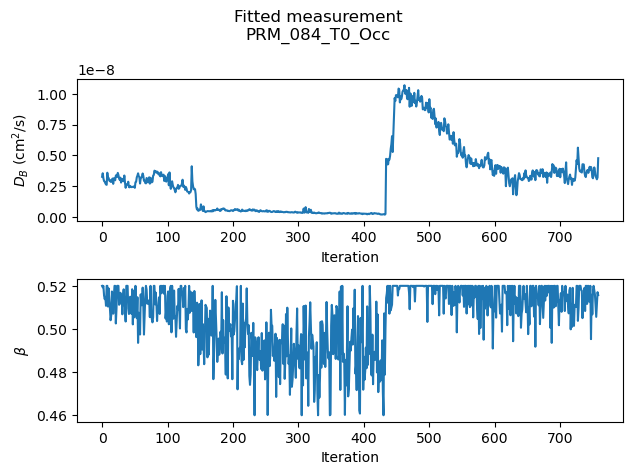

In [6]:
import inverse.fit_homogeneous as fit_hom
import forward.homogeneous_semi_inf as hsi

msd_model = fit_hom.MSDModelFit(model_name="brownian", param_init={"db": 1e-8}, param_bounds={"db": (0, None)})
beta_calculator =  fit_hom.BetaCalculator(mode="fit", beta_init=0.48, beta_bounds=(0.46, 0.52))

fitter = fit_hom.FitHomogeneous(
    tau,
    g2_norm_weighted_avg,
    hsi.g1_norm,
    msd_model,
    beta_calculator,
    tau_lims_fit=(1e-7, 1e-3),
    g2_lim_fit=1.13,
    mua=0.1,
    musp=10,
    rho=2.5,
    n=1.4,
    lambda0=785
)
fit_results = fitter.fit()

plt.subplot(2, 1, 1)
plt.plot(fit_results["db"])
plt.xlabel("Iteration")
plt.ylabel(r"$D_B$ (cm$^2$/s)")
plt.subplot(2, 1, 2)
plt.plot(fit_results["beta"])
plt.xlabel("Iteration")
plt.ylabel(r"$\beta$")
plt.suptitle(f"Fitted measurement\n{data_files[0].split('/')[1]}")
plt.tight_layout()
plt.show()

## Software correlator
The `.ttbin` files saved by the TimeTagger require the Swabian libraries to be read, which can be freely downloaded from
https://www.swabianinstruments.com/time-tagger/downloads/. Once those are installed (only the Python files are needed), the data loader
will function properly.

The `.ttbin` files store the raw time tags, from which we compute the autocorrelations. The first step is to define the architecture of
the software correlator. Since we are using a multi-tau correlator, the architecture can be specified through the following 3 integers:
* `s`: the number of cascaded linear correlators.
* `m`: the binning ratio between two consecutive linear correlators (in hardware correlators usually `m=2`).
* `p`: the number of bins in each linear correlator, it must be an integer multiple of `m`

While one can manually set `s`, `m`, and `p`, the `utils.timetagger` module provides the `get_correlator_architecture` function, which takes
as input the following arguments:
* `alpha = p / m`, which should be high enough to guarantee a good signal-to-noise ratio. For example, `alpha = 7` guarantees an
error the order of `1e-3`.
* `m`.
* `tau_max`, the maximum desired value of `tau` up to which to calculate the autocorrelation.
* `t0`, the resolution (in s) of the TimeTagger. The Swabian TimeTagger20 has a resolution of 1 ps, so we should set `t0 = 1e-12`.

`get_correlator_architecture` will then output `p` and `s`, like so:

In [7]:
from utils.timetagger import get_correlator_architecture

m = 2
(p, s) = get_correlator_architecture(alpha=7, m=m, tau_max=1e-2, t0=1e-12)
print(f"m={m}, p={p}, s={s}")

m=2, p=14, s=31


Now that we have defined the correlator architecture, we can load the data using the `data_loaders.DataLoaderTimeTagger` class, which
reads a measurement file and calculates the autocorrelation according to the specified architecture and integration time.

Let's load the file `TERm1010.ttbin`, which has a high countrate on channel 1, and calculate the autocorrelations for channel 1 with
integration time `30 ms`. To speed up the autocorrelation computation, we can pass the optional argument `tau_start`, which is the
minimum value of `tau` from which to calculate the autocorrelation. Since the detectors we use have a `20 ns` dead time, the autocorrelation
for `tau < 20 ns` will always be `0`, so we should set `tau_start` to at least `20e-9`. Since very early lag times are noisy, we
will set it a little higher, to `100 ns`.

Note that the `channels` argument must be a list even when using only 1 channel.

In [8]:
file = "data/TERm1010.ttbin"
integration_time = 30e-3
channels = [1]
tau_start = 1e-7
loader = data_loaders.DataLoaderTimeTagger(
    file,
    integration_time=integration_time,
    channels=channels,
    p=p,
    m=m,
    s=s,
    tau_start=tau_start
)

Similar to `DataLoaderALV`, we call `loader.load_data()`, which stores the results in the attributes `tau`, `g2_norm`, and `countrate`
(the following cell may take a couple minutes to execute, since it's calculating 300 autocorrelations):

In [9]:
loader.load_data()

Since we used `tau_start`, `g2_norm` is `0` for `tau < tau_start`, so we can discard those channels:

In [10]:
mask = loader.tau > tau_start
tau = loader.tau[mask]
g2_norm = loader.g2_norm[mask, ...]
countrate = loader.countrate

Note that, even though we have only analyzed 1 channel, `g2_norm` is still a 3D array:

In [11]:
print(g2_norm.shape)

(121, 300, 1)


To analyze it, we need to either average it over the last axis (like before), or in this case we can simply squeeze the array:

In [12]:
g2_norm = np.squeeze(g2_norm)
print(g2_norm.shape)

(121, 300)


Now we can perform our analysis. For example, we can again plot the countrate:

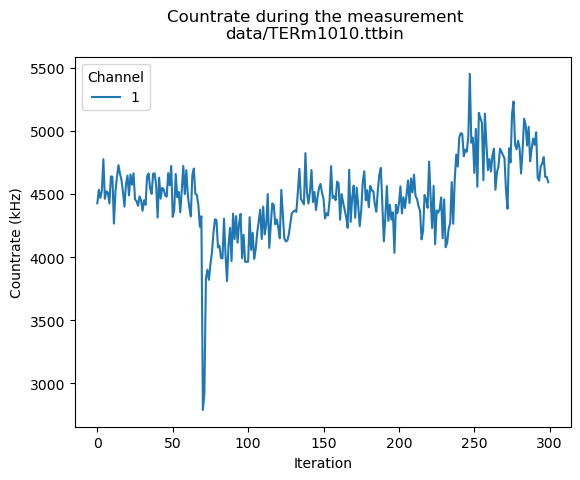

In [13]:
plt.plot(countrate)
plt.xlabel("Iteration")
plt.ylabel("Countrate (kHz)")
plt.legend("1", title="Channel")
plt.suptitle(f"Countrate during the measurement\n{file}")
plt.show()

Or we can fit the curves:

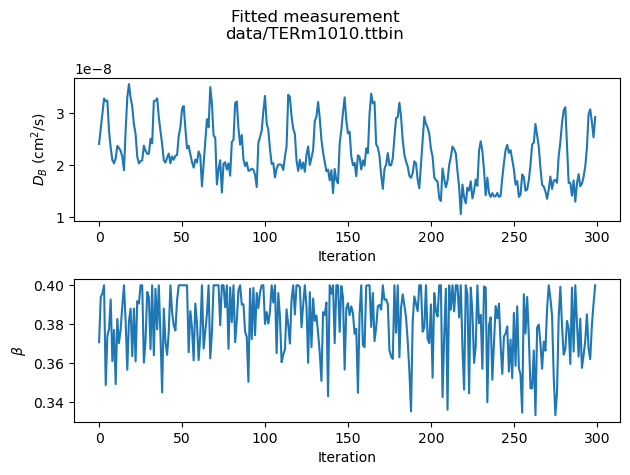

In [14]:
beta_calculator = fit_hom.BetaCalculator(mode="fit", beta_init=0.35, beta_bounds=(0.33, 0.4))
msd_model = fit_hom.MSDModelFit(model_name="brownian", param_init={"db": 1e-8}, param_bounds={"db": (0, None)})
fitter = fit_hom.FitHomogeneous(
    tau,
    g2_norm,
    hsi.g1_norm,
    msd_model,
    beta_calculator,
    tau_lims_fit=(3e-7, 8e-4),
    g2_lim_fit=1.13,
    mua=0.1,
    musp=10,
    rho=1,
    n=1.4,
    lambda0=785
)
fit_results = fitter.fit()

plt.subplot(2, 1, 1)
plt.plot(fit_results["db"])
plt.xlabel("Iteration")
plt.ylabel(r"$D_B$ (cm$^2$/s)")
plt.subplot(2, 1, 2)
plt.plot(fit_results["beta"])
plt.xlabel("Iteration")
plt.ylabel(r"$\beta$")
plt.suptitle(f"Fitted measurement\n{file}")
plt.tight_layout()
plt.show()